# Classifying Country

# Purpose: 
<h4 style='margin-bottom: 1;'> I analyzed Country music lyrics to uncover the genre's core themes through applying natural language techniques and diving into the stories that resonate with so many listeners. </h4>

![Alt text](Images/Classifying_Country_Scope.png)

# Featured Songs
## [Playlist: Click Here to Access via Spotify](https://open.spotify.com/playlist/6wS1RaOrTQiwlNTOuFyJcx?si=686ab2a0fa4444f0)

![Alt text](Images/Playlist_A.png)

![Alt text](Images/Playlist_B.png)

![Alt text](Images/Playlist_C.png)

# Initial Setup

In [1]:
# Import Required Libraries
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import random
import nltk
import ast
import re

# Import Specific Functions
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter, defaultdict
from tabulate import tabulate
from PIL import Image

# Ignore All Warnings 
warnings.filterwarnings('ignore')

# Download NLTK Files Only If They Haven't Been Downloaded Already
nltk.download('stopwords', quiet = True)

# Define gold_hex_codes for Visuals
gold_hex_codes = [
    '#FFC107', '#F3B500', '#E6A800', '#D99B00', '#CC8E00',
    '#C08200', '#B37500', '#A66800', '#995B00', '#8D4F00',
    '#804200', '#733500', '#662800', '#5A1C00', '#4D0F00',
    '#400200', '#330000', '#270000', '#1A0000', '#0D0000'
]

# Load Song Lyrics
song_lyrics = pd.read_excel('Data/song_lyrics.xlsx')
song_lyrics['Artists'] = song_lyrics['Artists'].apply(ast.literal_eval)
song_lyrics['Hometowns'] = song_lyrics['Hometowns'].apply(ast.literal_eval)

# Data Exploration

### Preprocess Song Lyrics

In [2]:
# Define Function to Preprocess Lyrics
def preprocess_lyrics(lyrics):
    stop_words = set(stopwords.words('english'))    
    
    # Process lyrics: clean and tokenize
    tokens = nltk.word_tokenize(re.sub(r'[^a-zA-Z\s]', '', lyrics.lower()))
    return tokens

# Apply Pre-Processing to the Lyrics Column
song_lyrics['Processed_Lyrics'] = song_lyrics['Lyrics'].apply(preprocess_lyrics)

# Define a Function to Merge Specific Patterns in Processed_Lyrics
def merge_tokens(tokens):
    corrected_tokens = []
    skip_next = False

    for i in range(len(tokens) - 1):
        if skip_next:
            skip_next = False
            continue

        # Merge Patterns Like 'wan na' -> 'wanna'
        if tokens[i] == 'wan' and tokens[i + 1] == 'na':
            corrected_tokens.append('wanna')
            skip_next = True
        elif tokens[i] == 'gon' and tokens[i + 1] == 'na':
            corrected_tokens.append('gonna')
            skip_next = True
        elif tokens[i] == 'got' and tokens[i + 1] == 'ta':
            corrected_tokens.append('gotta')
            skip_next = True
        else:
            corrected_tokens.append(tokens[i])

    # Add the Last token If It Wasn't Part of a Pair
    if not skip_next and len(tokens) > 0:
        corrected_tokens.append(tokens[-1])

    return corrected_tokens

# Apply the Correction Step to the Processed_Lyrics Column
song_lyrics['Processed_Lyrics'] = song_lyrics['Processed_Lyrics'].apply(merge_tokens)

# Convert Processed Lyrics Back to String Form for Analysis
song_lyrics['Processed_Text'] = song_lyrics['Processed_Lyrics'].apply(lambda x: ' '.join(x))

# Display the First Few Rows of the DataFrame
song_lyrics.head()

Song_Title Release_Date       Artists            Hometowns  \
0  Oklahoma Smokeshow   2022-07-15  [Zach Bryan]  [Oologah, Oklahoma]   
1       Heading South   2019-09-30  [Zach Bryan]  [Oologah, Oklahoma]   
2             Revival   2020-05-08  [Zach Bryan]  [Oologah, Oklahoma]   
3           Nine Ball   2023-09-22  [Zach Bryan]  [Oologah, Oklahoma]   
4         From Austin   2022-02-25  [Zach Bryan]  [Oologah, Oklahoma]   

                                              Lyrics  \
0  Go on and put on that dress that all the bad b...   
1  Was a boy who was a dreamer, and he flew so hi...   
2  Gather 'round this table, boys\nBring your sha...   
3  I don't wanna bet, but my father wrote a check...   
4  There is concrete below me and a sky above so ...   

                                    Processed_Lyrics  \
0  [go, on, and, put, on, that, dress, that, all,...   
1  [was, a, boy, who, was, a, dreamer, and, he, f...   
2  [gather, round, this, table, boys, bring, your...   
3  [i, dont, wanna, bet, but, my, father, wrote, ...   
4  [there, is, concrete, below, me, and, a, sky, ...   

                                      Processed_Text  
0  go on and put on that dress that all the bad b...  
1  was a boy who was a dreamer and he flew so hig...  
2  gather round this table boys bring your shame ...  
3  i dont wanna bet but my father wrote a check t...  
4  there is concrete below me and a sky above so ...

In [3]:
# This Function is Designed to Identify and Analyze the Original Context in Which Words Appear Within Song Lyrics
def initial_lyrics_analysis(lyrics_word_search, output_filename = 'Initial_Lyrics_Analysis.xlsx'):
    song_details = []

    # Extract All Words From Processed_Lyrics and Create a Set of Unique Words 
    all_processed_words = [word for lyrics in lyrics_word_search['Processed_Lyrics'] for word in lyrics]
    unique_words = set(all_processed_words)

    # Iterate Through Each Word to Find Word Occurrences in Lyrics
    for word in unique_words:
        # Iterate Through Each Song in the Dataset
        for index, row in lyrics_word_search.iterrows():
            lyrics = row['Lyrics']  # Original lyrics
            processed_text = row['Processed_Text']  # Punctuation-removed processed text

            # Count Word Occurrences in Processed_Text
            word_count_in_processed = processed_text.lower().split().count(word.lower())

            # If the Word is Found in Processed_Text, Extract Its Context
            if word_count_in_processed > 0:
                # Split the original Lyrics into Lines for Detailed Context
                original_lines = lyrics.split('\n')

                # Enumerate through lines to retain their order
                for line_number, original_line in enumerate(original_lines, start = 1):
                    
                    # Process the Line by Removing Punctuation and Convert to Lowercase
                    processed_line = re.sub(r'[^a-zA-Z\s]', '', original_line).lower()

                    # Check if the Word is Present in the Processed Line
                    matches = re.findall(rf'\b{re.escape(word)}\b', processed_line, flags = re.IGNORECASE)

                    if matches:
                        # Extract the List of Artists for the Song
                        artist_list = row['Artists']
                        hometown_list = row['Hometowns']

                        # Append the Extracted Details
                        song_details.append({
                            'Song_Title': row['Song_Title'],
                            'Release_Date': row['Release_Date'],
                            'Artists': artist_list,
                            'Hometowns': hometown_list,
                            'Word': word,
                            'Line_Number': line_number,
                            'Original_Line': original_line.strip(),
                            'Classification': '',  # Placeholder for Categorization
                            'Cnt_of_Word': len(matches)
                        })

    # Convert Results to a DataFrame
    song_details_df = pd.DataFrame(song_details)

    # Sort by Song Title and Line Number
    song_details_df = song_details_df.sort_values(by=['Song_Title', 'Line_Number', 'Word']).reset_index(drop=True)

    # Save to Excel
    song_details_df.to_excel(output_filename, index=False)

    # Return Results as a DataFrame
    return song_details_df

# Call the function
song_details_df = initial_lyrics_analysis(song_lyrics)
song_details_df.head()

Song_Title Release_Date                      Artists  \
0  1, 2 Many   2019-08-23  [Brooks & Dunn, Luke Combs]   
1  1, 2 Many   2019-08-23  [Brooks & Dunn, Luke Combs]   
2  1, 2 Many   2019-08-23  [Brooks & Dunn, Luke Combs]   
3  1, 2 Many   2019-08-23  [Brooks & Dunn, Luke Combs]   
4  1, 2 Many   2019-08-23  [Brooks & Dunn, Luke Combs]   

                                           Hometowns  Word  Line_Number  \
0  [Nashville, Tennessee, Huntersville, North Car...     a            1   
1  [Nashville, Tennessee, Huntersville, North Car...   one            1   
2  [Nashville, Tennessee, Huntersville, North Car...   two            1   
3  [Nashville, Tennessee, Huntersville, North Car...     a            2   
4  [Nashville, Tennessee, Huntersville, North Car...  call            2   

                                      Original_Line Classification  \
0                                        A one, two                  
1                                        A one, two                  
2                                        A one, two                  
3  Well, I got a call from Rowdy 'round six o'clock                  
4  Well, I got a call from Rowdy 'round six o'clock                  

   Cnt_of_Word  
0            1  
1            1  
2            1  
3            1  
4            1

### Extract Individual Artists that Worked on a Song

In [4]:
def get_artist_details(song_details_df):
    # Pair Artist, Hometown, and Number of Songs in Playlist
    artist_hometown_song_pairs = [
        (artist, hometown, row['Song_Title'])
        for _, row in song_details_df.iterrows()
        for artist, hometown in zip(row['Artists'], row['Hometowns'])
    ]

    # Convert to DataFrame
    artist_hometown_df = pd.DataFrame(
        artist_hometown_song_pairs, columns = ['Artist', 'Hometown', 'Song_Title']
    )

    # Count the Number of Unique Songs for Each Artist
    artist_data = (
        artist_hometown_df.groupby(['Artist', 'Hometown'])['Song_Title']
        .nunique()  # Count unique songs
        .reset_index(name = 'Number of Songs in Playlist')
        .sort_values(by = 'Number of Songs in Playlist', ascending = False)
        .reset_index(drop = True)
    )

    return artist_data

# Display Artist, Hometown, and the Number of Songs the Artist has featured on the Playlist
artist_details = get_artist_details(song_details_df)
artist_details

Artist                      Hometown  \
0              Willie Nelson                 Abbott, Texas   
1                 Luke Combs  Huntersville, North Carolina   
2                Johnny Cash           Kingsland, Arkansas   
3                Post Malone            Syracuse, New York   
4            Waylon Jennings            Littlefield, Texas   
5             Tyler Childers     Lawrence County, Kentucky   
6               Dolly Parton        Sevierville, Tennessee   
7          Hank Williams Jr.         Shreveport, Louisiana   
8              Billy Strings             Lansing, Michigan   
9                 Zach Bryan             Oologah, Oklahoma   
10             Morgan Wallen         Sneedville, Tennessee   
11              Loretta Lynn      Butcher Hollow, Kentucky   
12             Blake Shelton                 Ada, Oklahoma   
13           Chris Stapleton      Staffordsville, Kentucky   
14             Conway Twitty     Friars Point, Mississippi   
15               Colter Wall   Swift Current, Saskatchewan   
16             Dylan Gossett                 Austin, Texas   
17             Brooks & Dunn          Nashville, Tennessee   
18            Zac Brown Band              Atlanta, Georgia   
19          Sturgill Simpson             Jackson, Kentucky   
20             Hank Williams          Mount Olive, Alabama   
21                Jelly Roll          Nashville, Tennessee   
22          Flatland Cavalry                Lubbock, Texas   
23              Garth Brooks               Yukon, Oklahoma   
24                Evan Honer             Surprise, Arizona   
25             George Strait                 Poteet, Texas   
26          Carrie Underwood            Checotah, Oklahoma   
27           Parker McCollum                 Conroe, Texas   
28              Justin Moore               Poyen, Arkansas   
29            Oliver Anthony           Farmville, Virginia   
30             Lainey Wilson             Baskin, Louisiana   
31               John Denver           Roswell, New Mexico   
32              Jordan Davis         Shreveport, Louisiana   
33                Josh Meloy            Hennessy, Oklahoma   
34             Merle Haggard           Oildale, California   
35               Patsy Cline          Winchester, Virginia   
36  Shane Smith & the Saints                 Austin, Texas   
37            Sierra Ferrell     Charleston, West Virginia   
38              Randy Travis    Marshville, North Carolina   
39             Reba McEntire             Chockie, Oklahoma   
40        Kris Kristofferson            Brownsville, Texas   
41              Cody Johnson             Sebastopol, Texas   
42              Gwen Stefani           Anaheim, California   
43           Miranda Lambert                Lindale, Texas   
44             Jimmy Buffett               Mobile, Alabama   
45                Luke Bryan             Leesburg, Georgia   
46             Pistol Annies          Nashville, Tennessee   
47           Trisha Yearwood           Monticello, Georgia   
48                 Tom Petty           Gainsville, Florida   
49              Trace Adkins            Sarepta, Louisiana   

    Number of Songs in Playlist  
0                             9  
1                             8  
2                             7  
3                             7  
4                             7  
5                             6  
6                             6  
7                             6  
8                             6  
9                             6  
10                            6  
11                            6  
12                            6  
13                            5  
14                            5  
15                            5  
16                            5  
17                            5  
18                            5  
19                            5  
20                            5  
21                            5  
22                            5  
23                            5  
24       

### Number of Songs by Top Featured Artists Visual

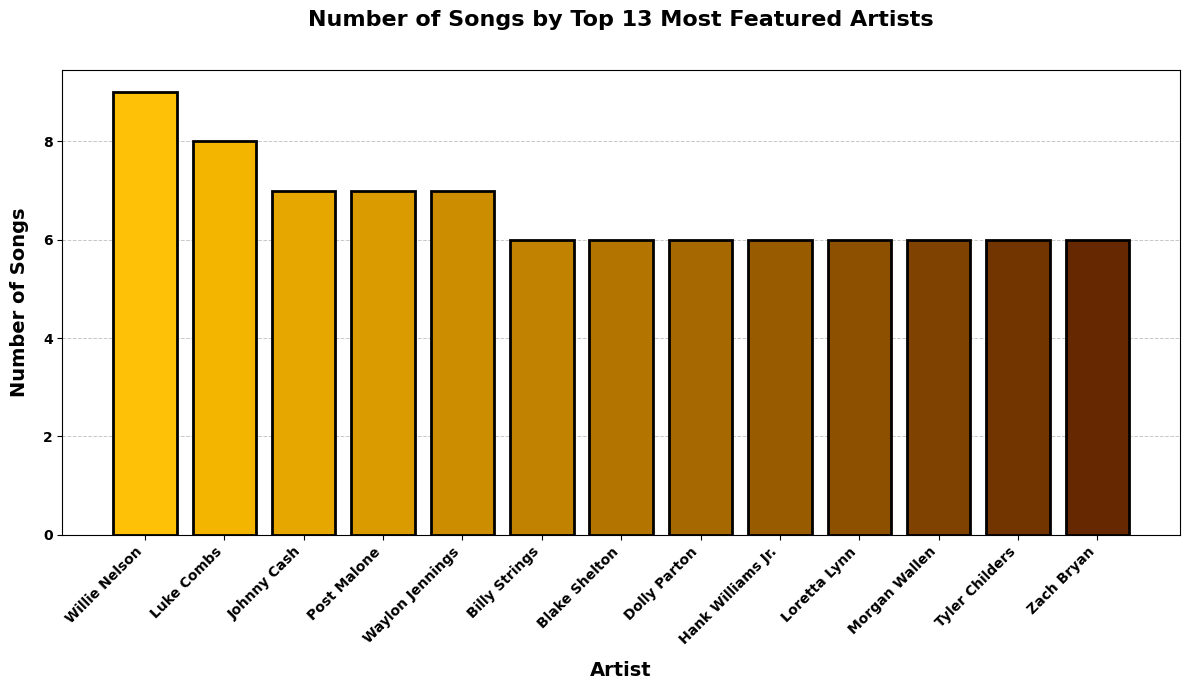

In [5]:
# Sort Data to Display the Top Artists
artist_data_sorted = artist_details.sort_values(
    by = ['Number of Songs in Playlist', 'Artist'], 
    ascending = [False, True]
).head(13)

# Create the Bar Plot
plt.figure(figsize = (12, 7))
plt.bar(artist_data_sorted['Artist'], artist_data_sorted['Number of Songs in Playlist'], color = gold_hex_codes, edgecolor = 'black', linewidth = 2)

# Add Title and Labels
plt.title('Number of Songs by Top 13 Most Featured Artists\n', fontsize = 16, fontweight = 'bold', pad = 15)
plt.xlabel('Artist', fontsize = 14, labelpad = 10, fontweight = 'bold')
plt.ylabel('Number of Songs', fontsize = 14, labelpad = 10, fontweight = 'bold')

# Customize Ticks
plt.xticks(rotation = 45, ha = 'right', fontsize = 10, fontweight = 'bold')
plt.yticks(fontsize = 10, fontweight = 'bold')

# Add Gridlines and Ensure They are Behind Bars
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.7, alpha = 0.7)
plt.gca().set_axisbelow(True)

# Optimize Layout and Display
plt.tight_layout()
plt.show()

### Geocode Artist Hometowns and Visualize Collaborations

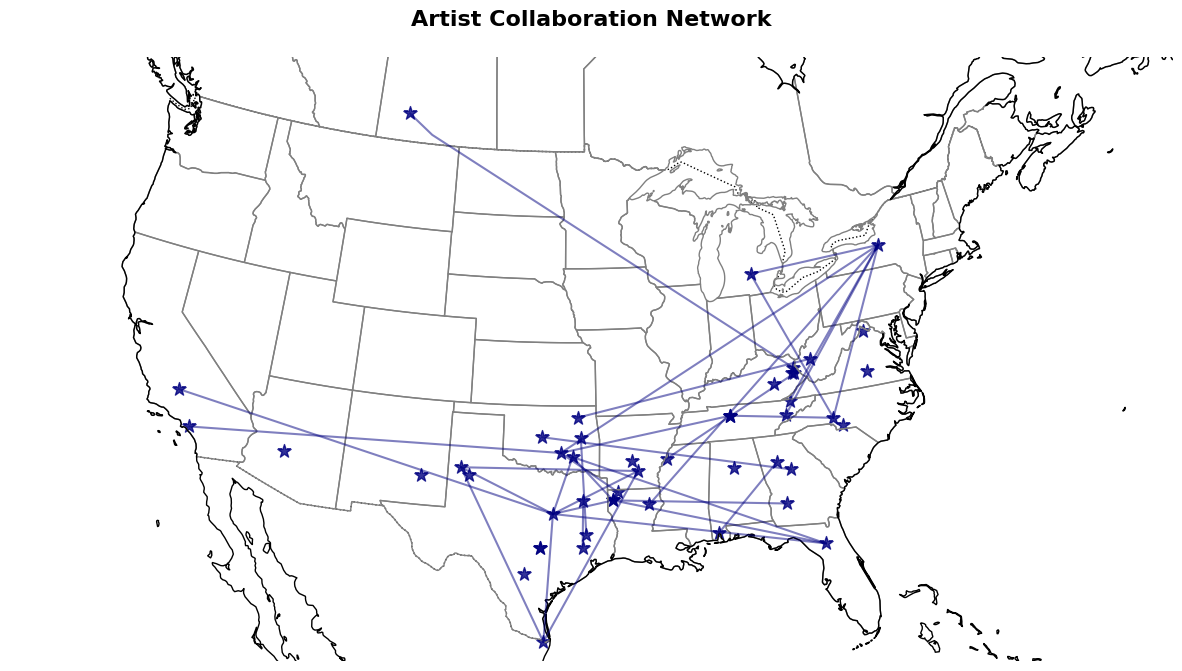

In [6]:
# Geocode Artist Hometown
geolocator = Nominatim(user_agent = 'artist_map')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Add Latitude and Longitude to artist_details
artist_details['Location'] = artist_details['Hometown'].apply(geocode)
artist_details['Latitude'] = artist_details['Location'].apply(lambda loc: loc.latitude if loc else None)
artist_details['Longitude'] = artist_details['Location'].apply(lambda loc: loc.longitude if loc else None)

# Create a Graph for Artist Collaboration
G = nx.Graph()

# Add Nodes for Each Artist with Latitude and Longitude as Attributes
for _, row in artist_details.iterrows():
    G.add_node(row['Artist'], pos = (row['Longitude'], row['Latitude']), hometown = row['Hometown'])

collaboration_data = set()

# Add Edges for Collaborations
for _, row in song_details_df.drop_duplicates(subset = ['Song_Title']).iterrows():
    artists = row['Artists']
    if len(artists) > 1:
        for i in range(len(artists)):
            for j in range(i + 1, len(artists)):
                if G.has_node(artists[i]) and G.has_node(artists[j]):
                    G.add_edge(artists[i], artists[j])
                    collaboration_data.add(row['Song_Title'])

# Get the Number of Plotted Artists
plotted_artists = {artist for artist, data in G.nodes(data = True) if data['pos'][0] and data['pos'][1]}

# Get the Number of Artists with at Least One Collaboration
artists_with_collab = set([node for edge in G.edges() for node in edge])

# Set up Cartopy map with Lambert Conformal projection
fig, ax = plt.subplots(figsize = (15, 10), subplot_kw = {'projection': ccrs.LambertConformal()})
ax.set_extent([-125, -65, 25, 50], crs=ccrs.PlateCarree())  # Zoom into central/eastern US

# Add Country, State, and Coastline Boundaries
ax.add_feature(cfeature.BORDERS, linestyle = ':', edgecolor = 'black')
ax.add_feature(cfeature.STATES, edgecolor = 'gray')  # Add U.S. state boundaries
ax.add_feature(cfeature.COASTLINE)

# Get Positions for Nodes from the Graph
pos = {artist: (data['pos'][0], data['pos'][1]) for artist, data in G.nodes(data=True) if data['pos'][0] and data['pos'][1]}

# Plot Nodes as Points on the Map
for artist, (lon, lat) in pos.items():
    ax.scatter(lon, lat, transform = ccrs.PlateCarree(), color = '#000080', marker = '*', s = 100, alpha = 0.8)

# Draw Collaborations as Lines on the Map
for u, v in G.edges():
    if u in pos and v in pos:
        x = [pos[u][0], pos[v][0]]
        y = [pos[u][1], pos[v][1]]
        ax.plot(x, y, transform = ccrs.PlateCarree(), color = '#000080', alpha = 0.5)

plt.title('Artist Collaboration Network\n', fontsize = 16, fontweight = 'bold')
plt.axis('off')
plt.show()

### Number of Collaborations between Artists

In [7]:
# Print Key Collaboration Information
print(f'Total number of plotted artists: {len(plotted_artists)}')
print(f'Total number of collaborations: {len(collaboration_data)}')
print(f'Total number of artists with at least one collaboration: {len(artists_with_collab)}')

Total number of plotted artists: 50
Total number of collaborations: 26
Total number of artists with at least one collaboration: 35


### Artist Collaborations

![Alt text](Images/Collabs_A.png)

![Alt text](Images/Collabs_B.png)

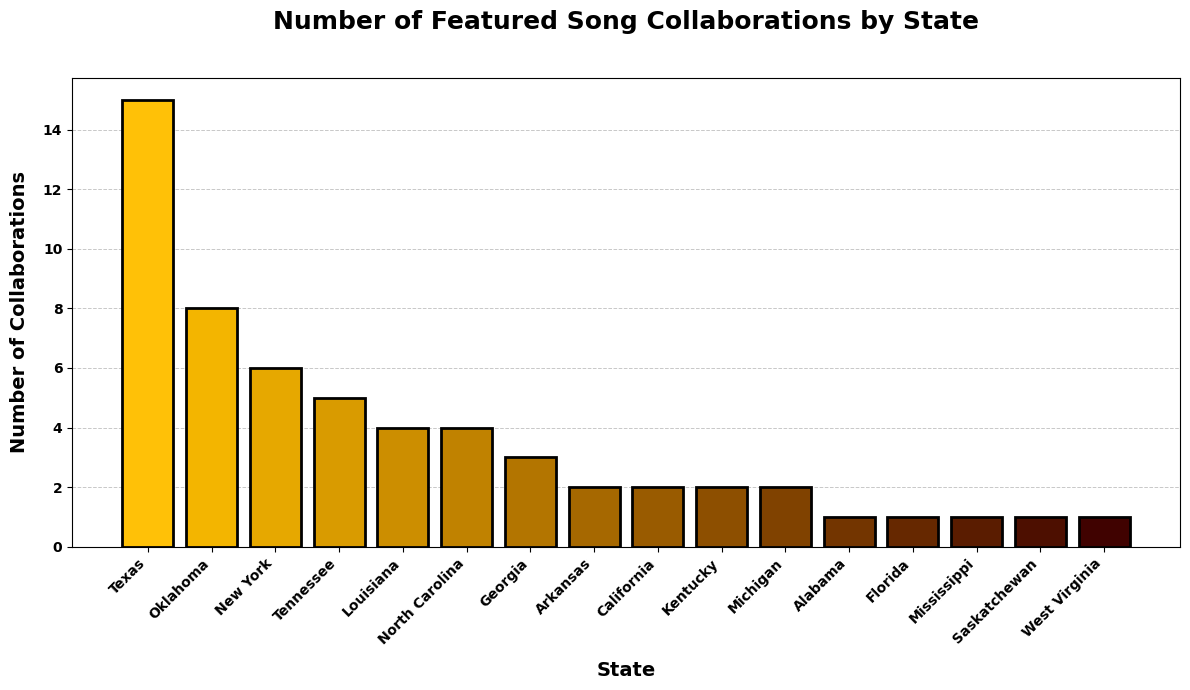

In [8]:
# Filter rows where Song_Title is in collaboration_data
filtered_df = song_details_df[song_details_df['Song_Title'].isin(collaboration_data)][['Song_Title', 'Hometowns']]

# Convert Hometowns Lists to Tuples in the Filtered DataFrame to Allow Dropping Duplicates
filtered_df['Hometowns'] = filtered_df['Hometowns'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Drop duplicates based on Song_Title and Hometowns
filtered_df = filtered_df.drop_duplicates()

# Initialize a Dictionary to Count Collaborations by State
state_collaborations = {}

# Process Each Row in filtered_df to Calculate Collaborations by State
for _, row in filtered_df.iterrows():
    if isinstance(row['Hometowns'], tuple):
        # Extract States for All Artists in the Collaboration
        states = [hometown.split(', ')[-1] for hometown in row['Hometowns'] if ', ' in hometown]
        
        # Count Each State Based on the Number of Artists from that State
        for state in states:
            state_collaborations[state] = state_collaborations.get(state, 0) + 1

# Convert the state_collaborations Dictionary into a Dataframe for Sorting
state_counts_df = (
        pd.DataFrame(list(state_collaborations.items()), columns = ['State', 'Count'])
        .sort_values(by = ['Count','State'], ascending = [False, True])
    )

# Convert the Sorted Dataframe Back to Series for Plotting
state_counts = state_counts_df.set_index('State')['Count']

# Create the Bar Graph
plt.figure(figsize = (12, 7))
plt.bar(state_counts.index, state_counts.values, color = gold_hex_codes, edgecolor = 'black', linewidth = 2, width = 0.8)

# Add Title and Labels
plt.title('Number of Featured Song Collaborations by State\n', fontsize = 18, fontweight = 'bold', pad = 15)
plt.xlabel('State', fontsize = 14, labelpad = 10, fontweight = 'bold')
plt.ylabel('Number of Collaborations', fontsize = 14, labelpad = 10, fontweight = 'bold')

# Customize Ticks with Bold Font
plt.xticks(rotation = 45, ha = 'right', fontsize = 10, fontweight = 'bold')
plt.yticks(fontsize = 10, fontweight = 'bold')

# Add Gridlines and Ensure They are Behind Bars
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.7, alpha = 0.7)
plt.gca().set_axisbelow(True)

# Optimize Layout and Display
plt.tight_layout()
plt.show()

### Song Releases Over Time

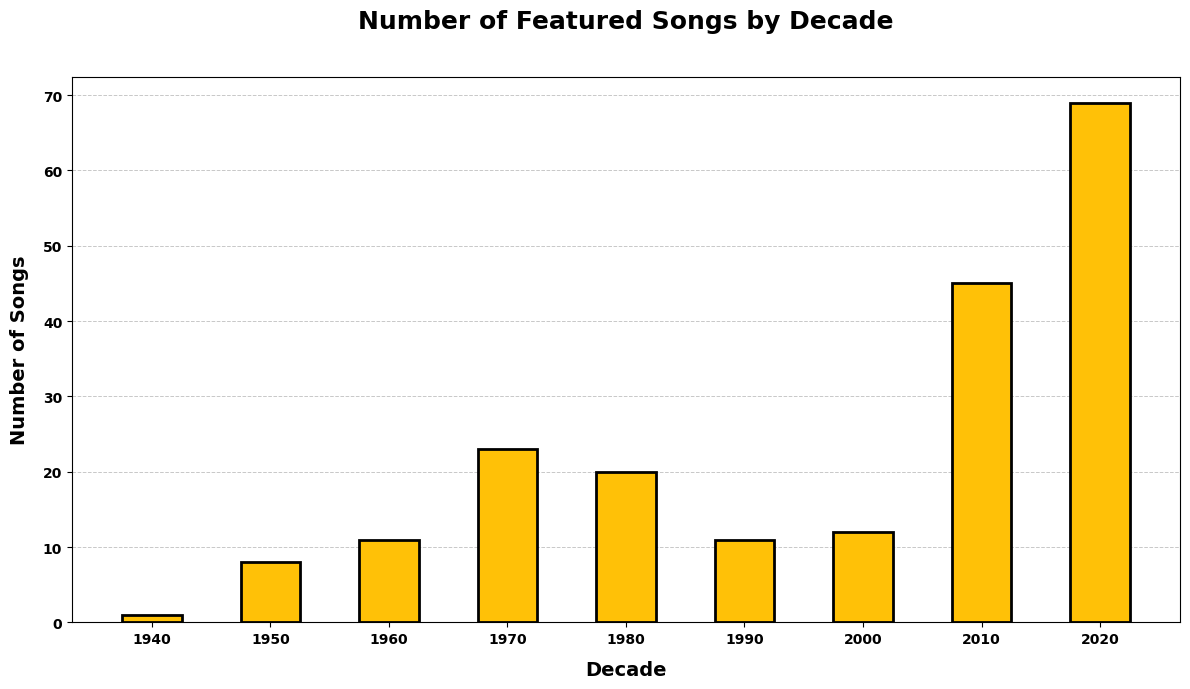

In [9]:
# Remove Duplicates Based on 'Song_Title'
unique_songs_df = song_details_df.drop_duplicates(subset = ['Song_Title'])

# Group by Decade, Count the Number of Unique Songs
unique_songs_df['Decade'] = (unique_songs_df['Release_Date'].dt.year // 10) * 10
songs_by_decade = unique_songs_df['Decade'].value_counts().sort_index()

# Create the Bar Graph
plt.figure(figsize = (12, 7))
plt.bar(songs_by_decade.index, songs_by_decade.values, color = '#FFC107', edgecolor = 'black', linewidth = 2, width = 5)

# Add Title and Labels
plt.title('Number of Featured Songs by Decade\n', fontsize = 18, fontweight = 'bold', pad = 15)
plt.xlabel('Decade', fontsize = 14, labelpad = 10, fontweight = 'bold')
plt.ylabel('Number of Songs', fontsize = 14, labelpad = 10, fontweight = 'bold')

# Customize Ticks with Bold Font
plt.xticks(range(1940, 2030, 10), fontsize = 10, fontweight = 'bold', rotation = 0)
plt.yticks(fontsize=10, fontweight='bold')

# Add Gridlines and Ensure They are Behind Bars
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.7, alpha = 0.7)
plt.gca().set_axisbelow(True)

# Optimize layout and Display
plt.tight_layout()
plt.show()

# Classifying Country

![Alt text](Images/Themes.png)

## Load Cleaned Lyrics Analysis - Lines Categorized Sheet

In [10]:
# Load Cleaned Data with Lines from Featured Songs Cleaned and Classified
lines_categorized = pd.read_excel('Data/Lyrics_Analysis_Cleaned.xlsx', sheet_name = 'Lines_Categorized')

# Convert Release_Date to DateTime
lines_categorized['Release_Date'] = pd.to_datetime(lines_categorized['Release_Date'])

# Extract Year from Release Date
lines_categorized['Year'] = lines_categorized['Release_Date'].dt.year

# Extract Decades from Release Date
lines_categorized['Decade'] = (lines_categorized['Year'] // 10 * 10).astype(int)

lines_categorized.head()

Song_Title Release_Date                      Artist_List  \
0  1, 2 Many   2019-08-23  ['Brooks & Dunn', 'Luke Combs']   
1  1, 2 Many   2019-08-23  ['Brooks & Dunn', 'Luke Combs']   
2  1, 2 Many   2019-08-23  ['Brooks & Dunn', 'Luke Combs']   
3  1, 2 Many   2019-08-23  ['Brooks & Dunn', 'Luke Combs']   
4  1, 2 Many   2019-08-23  ['Brooks & Dunn', 'Luke Combs']   

                                            Hometown  Line_Number  \
0  ['Nashville, Tennessee', 'Huntersville, North ...            1   
1  ['Nashville, Tennessee', 'Huntersville, North ...            2   
2  ['Nashville, Tennessee', 'Huntersville, North ...            3   
3  ['Nashville, Tennessee', 'Huntersville, North ...            4   
4  ['Nashville, Tennessee', 'Huntersville, North ...            5   

                                      Original_Line  \
0                                        A one, two   
1  Well, I got a call from Rowdy 'round six o'clock   
2     Sayin' he caught a hankerin' for a honky-tonk   
3         Wants an ice-cold beer and a country song   
4     But he didn't want to stay out all night long   

                  Classification  Year  Decade  
0                       Outliers  2019    2010  
1     Family, Friends, and Roots  2019    2010  
2  Music, Dance, and Celebration  2019    2010  
3     Consumption and Indulgence  2019    2010  
4                  Life and Time  2019    2010

## Ranked Popularity by Line Occurrences

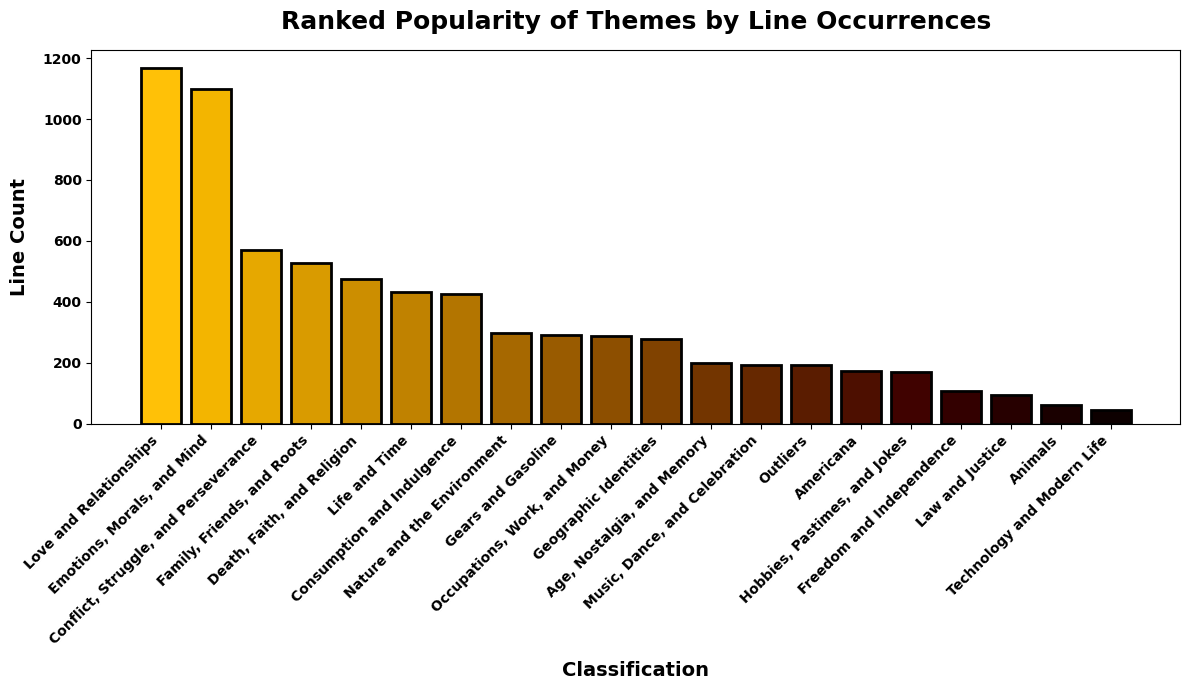

In [11]:
# Group by Decade and Classification, Count Line Occurrences
classification_counts = lines_categorized.groupby('Classification').size().reset_index(name='Count')

# Sort by Count (Descending) and Categorization (Alphabetical)
classification_counts = classification_counts.sort_values(by=['Count','Classification'], ascending=[False, True])

# Plot the Bar Chart
plt.figure(figsize=(12, 7))
plt.bar(classification_counts['Classification'], classification_counts['Count'], color=gold_hex_codes, edgecolor='black', linewidth=2, width=0.8)
plt.title('Ranked Popularity of Themes by Line Occurrences', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Classification', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('Line Count', fontsize=14, labelpad=10, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()

## Decade Trends

### Setup Functions for Evaluating Trends of Themes Across Time

In [12]:
theme_order = [
    'Love and Relationships',
    'Emotions, Morals, and Mind',
    'Conflict, Struggle, and Perseverance',
    'Family, Friends, and Roots',
    'Death, Faith, and Religion',
    'Life and Time',
    'Consumption and Indulgence',
    'Nature and the Environment',
    'Gears and Gasoline',
    'Occupations, Work, and Money',
    'Geographic Identities',
    'Age, Nostalgia, and Memory',
    'Music, Dance, and Celebration',
    'Outliers',
    'Americana',
    'Hobbies, Pastimes, and Jokes',
    'Freedom and Independence',
    'Law and Justice',
    'Animals',
    'Technology and Modern Life'
]

def prepare_heatmap(df, grouping, classification, line_count, time):
    grouped = (df.groupby([grouping, classification])
               .size()
               .reset_index(name = line_count))
    grouped_merge = grouped.merge(time, on = grouping, how = 'right').fillna(0)
    heatmap_data = grouped_merge.pivot(index = classification, columns = grouping, values = line_count).fillna(0)
    return heatmap_data

def plot_heatmap(df, title, xlabel, ylabel, cmap = "cividis"):
    plt.figure(figsize = (14,8))
    sns.heatmap(df, cmap = cmap, annot = True, fmt = ".0f", linewidth = 0.5, cbar_kws = {'label': 'Line Count'})
    plt.title(title, fontsize = 18, fontweight = 'bold', pad = 15)
    plt.xlabel(xlabel, fontsize = 14, fontweight = 'bold')
    plt.ylabel(ylabel, fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 10, fontweight = 'bold', rotation = 45, ha = 'right')
    plt.yticks(fontsize = 10, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

def assign_range(df, col='Year'):
    df = df.copy()
    bins = [2000, 2004, 2008, 2012, 2016, 2020]
    labels = ['2000-2003', '2004-2007', '2008-2011', '2012-2015', '2016-2019']    
    df['Year_Range'] = pd.cut(df[col], bins=bins, labels=labels, right=False)
    return df

### Decade Trends - Post World War II

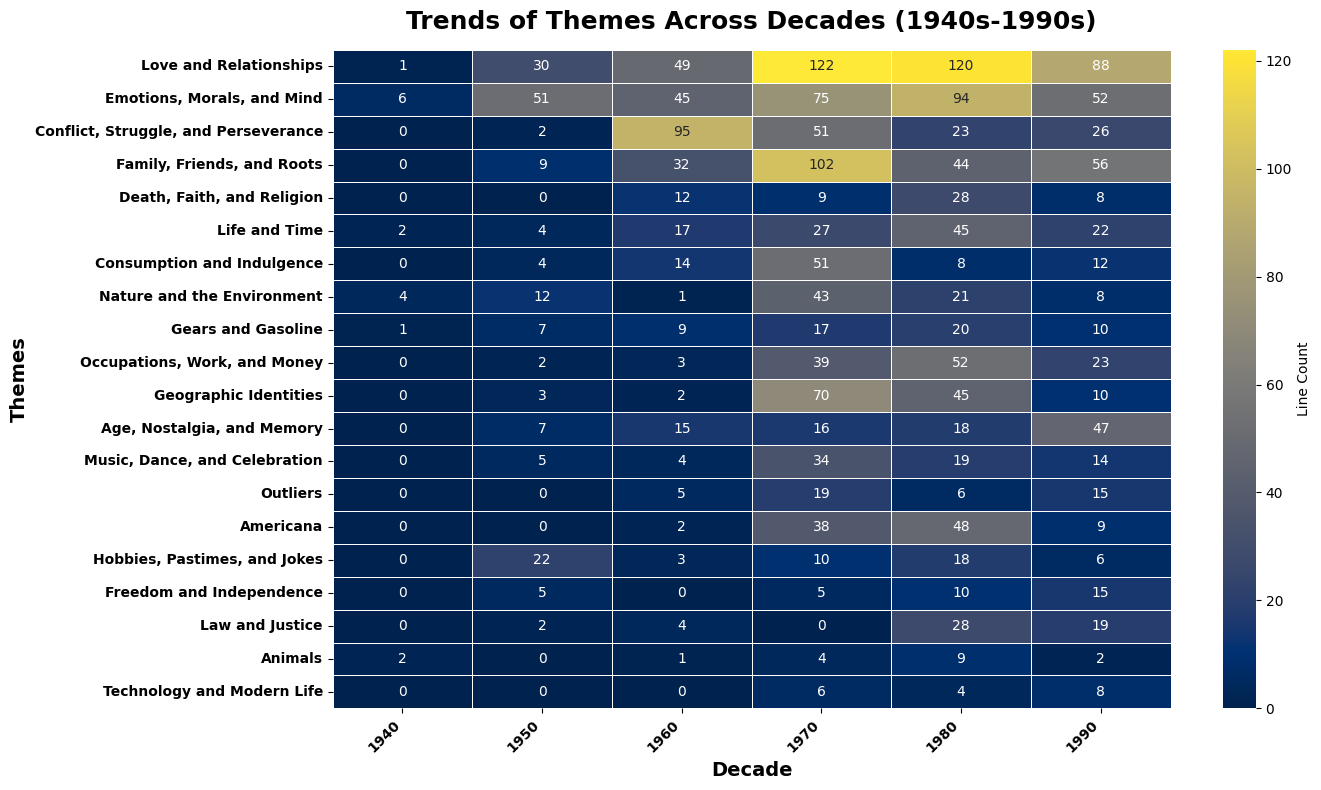

In [13]:
# Define the Ranges for Decades (1940-1999)
time = pd.DataFrame({'Decade': np.arange(1940, 2000, 10)})

# Analyze Themes Across Decades (1940-1999)
decades = lines_categorized[lines_categorized['Decade'] < 2000]

# Prepare Heatmap
decades_theme_ht = prepare_heatmap(
                                    df = decades, 
                                    grouping = 'Decade', 
                                    classification = 'Classification', 
                                    line_count = 'Line_Number', 
                                    time = time,
                                  )

# Reorder Themes
decades_theme_ht = decades_theme_ht.reindex(theme_order)

# Plot Heatmap
plot_heatmap(
              df = decades_theme_ht, 
              title = 'Trends of Themes Across Decades (1940s-1990s)', 
              xlabel = 'Decade', 
              ylabel = 'Themes'
            )

### Decade Trends - Turn of the Century

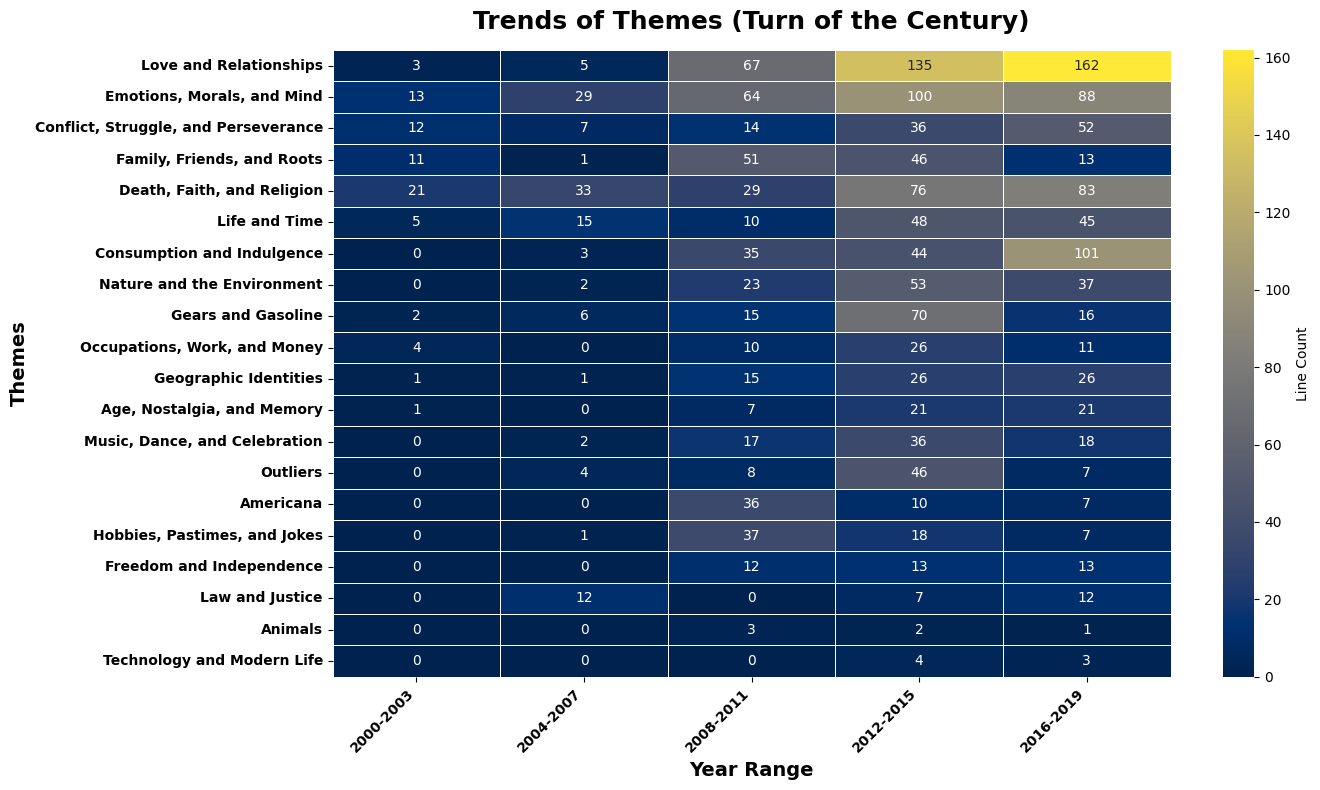

In [14]:
# Analyze Themes for 21st Century
after_1999 = lines_categorized[(lines_categorized['Year'] >= 2000) & (lines_categorized['Year'] < 2020)]

# Assign Year Ranges
after_1999 = assign_range(after_1999, col = 'Year')

# Define the Time DataFrame
time = pd.DataFrame({'Year_Range': after_1999['Year_Range'].cat.categories})

# Prepare Heatmap
after_1999_ht = prepare_heatmap(
                                 df = after_1999,
                                 grouping = 'Year_Range',
                                 classification = 'Classification',
                                 line_count = 'Line_Number',
                                 time = time
                               )
# Reorder Themes
after_1999_ht = after_1999_ht.reindex(theme_order)

# Plot Heatmap
plot_heatmap(
              df = after_1999_ht,
              title = 'Trends of Themes (Turn of the Century)',
              xlabel = 'Year Range',
              ylabel = 'Themes'
            )


### Decade Trends - Post Covid

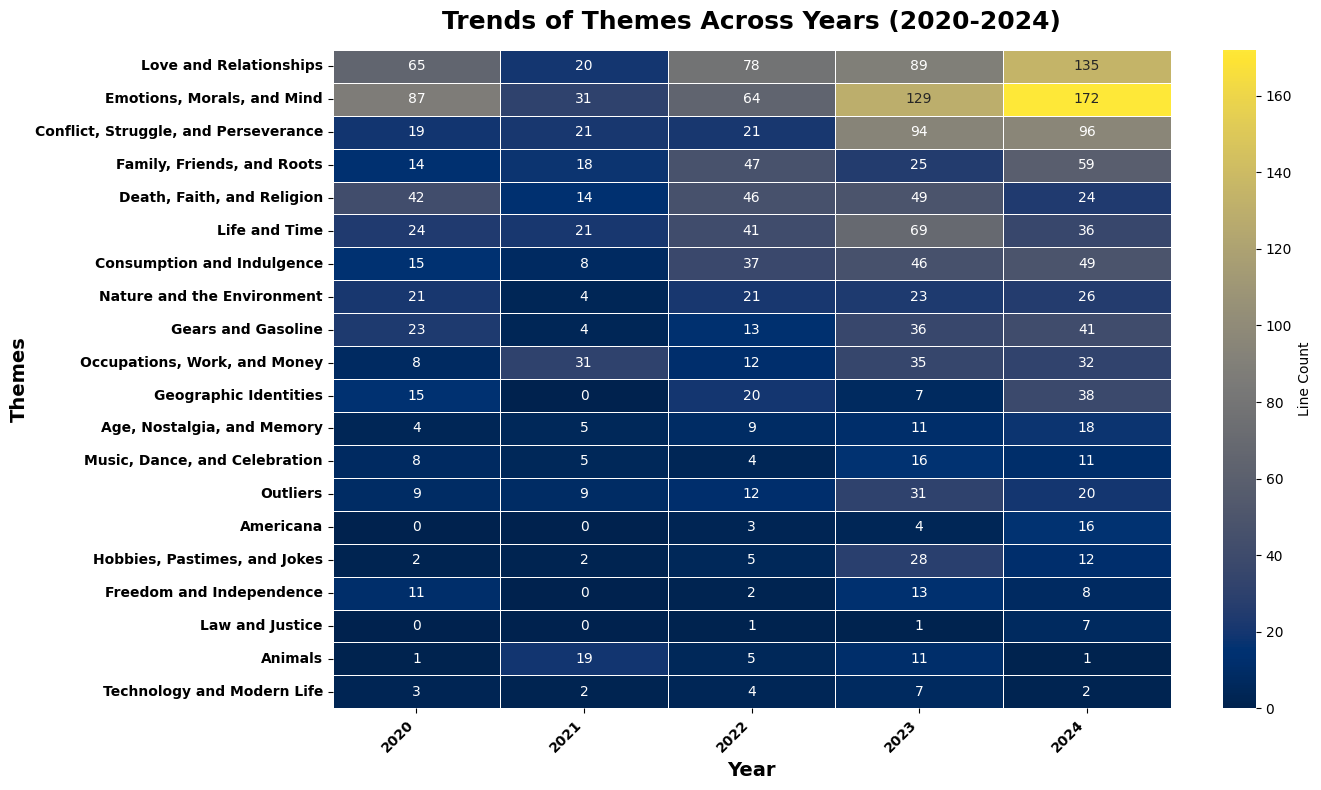

In [15]:
# Filter Data for 2020-2024
data_2020_2024 = lines_categorized[(lines_categorized['Year'] >= 2020) & (lines_categorized['Year'] <= 2024)]

# Use Year Column as the Grouping
data_2020_2024['Year'] = data_2020_2024['Year'].astype(str)

# Define Time with Individual Years
time = pd.DataFrame({'Year': ['2020', '2021', '2022', '2023', '2024']})

# Prepare Heatmap
data_2020_2024_ht = prepare_heatmap(
                                     df = data_2020_2024,
                                     grouping = 'Year',
                                     classification = 'Classification',
                                     line_count = 'Line_Number',
                                     time = time
                                   )

# Reorder Themes
data_2020_2024_ht = data_2020_2024_ht.reindex(theme_order)

# Plot Heatmap
plot_heatmap(
    df=data_2020_2024_ht,
    title='Trends of Themes Across Years (2020-2024)',
    xlabel='Year',
    ylabel='Themes',
)

### Load Cleaned Lyrics Analysis - Lyrics in Context Sheet

In [16]:
# Load Cleaned Data with Lyrics from Featured Songs Cleaned and Classified
lyrics_categorized = pd.read_excel('Data/Lyrics_Analysis_Cleaned.xlsx', sheet_name = 'Lyrics_in_Context')

# Convert Release_Date to DateTime
lyrics_categorized['Release_Date'] = pd.to_datetime(lyrics_categorized['Release_Date'])

# Define Stopwords and Irrelevant Words
stop_words = set(stopwords.words('english'))
irrelevant_words = {"dont", "got", "im", "aint", "yeah", "gonna", "youre", "cant", "like", "get", "back", "one",
                    "take", "know", "thing", "around", "ive", "I'll", "em", "theres", "ooh", "lets", "yeah",
                    "let", "go", "whoa", "oh", "even", "well", "'cause", "side", "tell", "we're", "thats",
                    "said", "hey", "round", "way", "hes", "bout", "many", "say", "took"}

# Combine Stopwords with Irrelevant Words
all_stopwords = stop_words.union(irrelevant_words)

# Filter out Stopwords
lyrics_categorized = lyrics_categorized[~lyrics_categorized['Word'].isin(all_stopwords)]

lyrics_categorized.head()

Song_Title Release_Date  \
1306          Highwayman   1985-03-29   
1307  Away From The Mire   2019-09-27   
1308        Too Far Gone   2023-04-28   
1420    All I See Is You   2015-09-11   
1421    Before He Cheats   2005-11-14   

                                            Artist_List  \
1306  ['Willie Nelson', 'Johnny Cash', 'Waylon Jenni...   
1307                                  ['Billy Strings']   
1308                                     ['Evan Honer']   
1420                       ['Shane Smith & the Saints']   
1421                               ['Carrie Underwood']   

                                               Hometown    Word  Line_Number  \
1306  ['Abbott, Texas', 'Kingsland, Arkansas', 'Litt...   abide            9   
1307                              ['Lansing, Michigan']    able           34   
1308                              ['Surprise, Arizona']    able           28   
1420                                  ['Austin, Texas']  abroad           14   
1421                             ['Checotah, Oklahoma']  acause           30   

                              Original_Line  \
1306           And with the sea I did abide   
1307         We'll be ready and able to fly   
1308          I'd be able to feel something   
1420  And I remember our first night abroad   
1421  A-'cause the next time that he cheats   

                            Classification  Cnt_of_Word  
1306            Nature and the Environment            1  
1307              Freedom and Independence            1  
1308            Emotions, Morals, and Mind            1  
1420            Age, Nostalgia, and Memory            1  
1421  Conflict, Struggle, and Perseverance            1

## Popular Words in Themes

### Setup Color Scheme

In [17]:
# Define the custom color palette
primary_color = '#C00000'  # Primary color
secondary_colors = ['#8D4F00', '#400200']  # Secondary colors

# Color function
def custom_colors(word, **kwargs):
    # Prioritize primary color with a higher probability
    colors = [primary_color] * 2 + secondary_colors
    return random.choice(colors)

### Define WordCloud Function

In [18]:
# Define WordCloud Function and Get Top 10 Words
def generate_wordcloud_and_top_words(classification, top_n = 10):
    
    # Filter Data for the Specified Classification
    filtered_data = lyrics_categorized[lyrics_categorized['Classification'] == classification]

    # Create a Dictionary with Words and Their Frequencies
    word_frequencies = filtered_data.groupby('Word')['Cnt_of_Word'].sum().to_dict()

    # Generate the WordCloud
    wordcloud = WordCloud(
                            width = 800,
                            height = 400,
                            background_color = 'white',
                            color_func = custom_colors,
                            prefer_horizontal = 1.0
                         ).generate_from_frequencies(word_frequencies)

    # Plot the WordCloud
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(classification, fontsize = 16)
    plt.show()

    # Get the Top N Words with Their Counts
    top_words = sorted(word_frequencies.items(), key = lambda x: x[1], reverse = True)[:top_n]

    print(f'Top {top_n} most popular words with their counts for {classification}:')
    for word, count in top_words:
        print(f'{word}: {count}')

### Love and Relationships

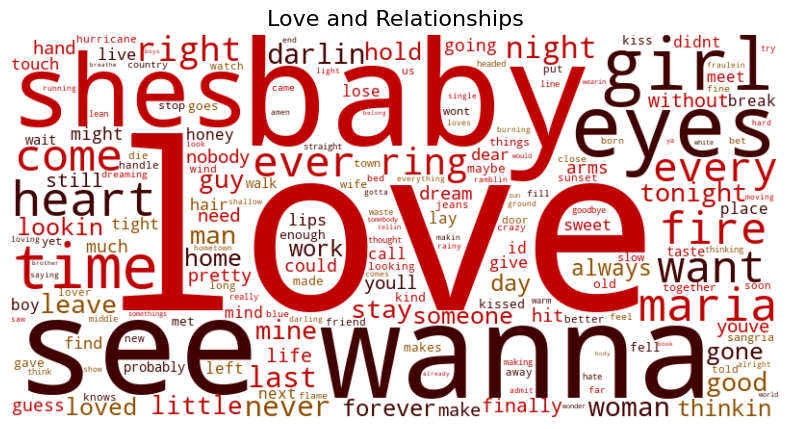

Top 10 most popular words with their counts for Love and Relationships:
love: 196
baby: 62
see: 53
wanna: 50
shes: 42
eyes: 40
girl: 37
time: 37
heart: 36
maria: 33


In [19]:
generate_wordcloud_and_top_words('Love and Relationships')

### Emotions, Morals, and Mind

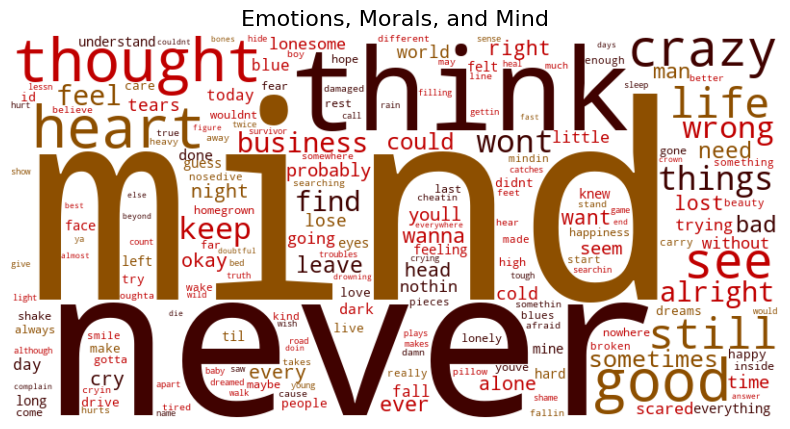

Top 10 most popular words with their counts for Emotions, Morals, and Mind:
mind: 51
never: 31
think: 29
thought: 29
good: 27
heart: 27
crazy: 24
see: 23
still: 23
life: 22


In [20]:
generate_wordcloud_and_top_words('Emotions, Morals, and Mind')

### Conflict, Struggle, and Perseverance

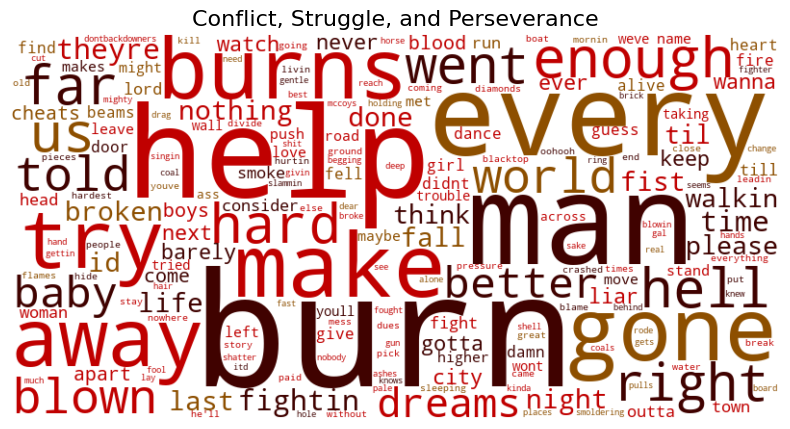

Top 10 most popular words with their counts for Conflict, Struggle, and Perseverance:
burn: 33
help: 20
man: 20
every: 16
gone: 16
make: 16
burns: 15
away: 14
try: 14
enough: 13


In [21]:
generate_wordcloud_and_top_words('Conflict, Struggle, and Perseverance')

### Family, Friends, and Roots

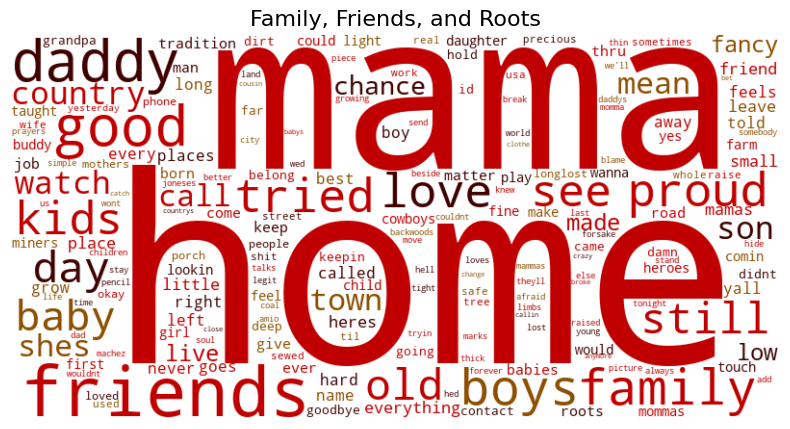

Top 10 most popular words with their counts for Family, Friends, and Roots:
home: 53
mama: 37
friends: 32
daddy: 21
good: 20
boys: 15
family: 15
love: 14
proud: 14
tried: 14


In [22]:
generate_wordcloud_and_top_words('Family, Friends, and Roots')

### Death, Faith, and Religion

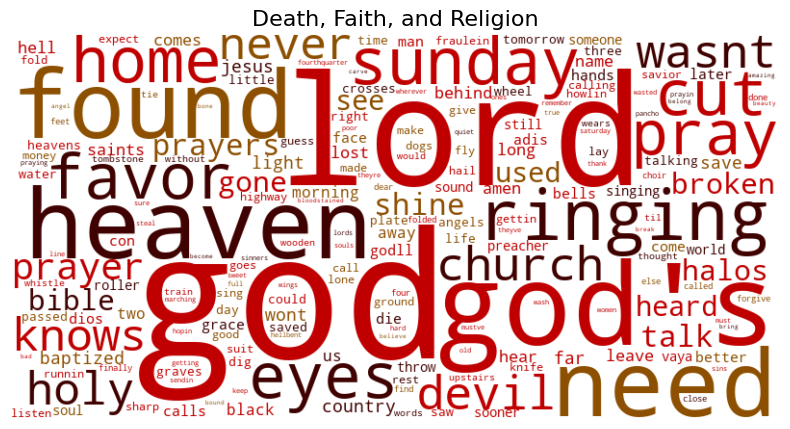

Top 10 most popular words with their counts for Death, Faith, and Religion:
god: 42
lord: 31
god's: 17
heaven: 17
found: 16
need: 16
ringing: 15
sunday: 14
cut: 13
eyes: 13


In [23]:
generate_wordcloud_and_top_words('Death, Faith, and Religion')

### Life and Time

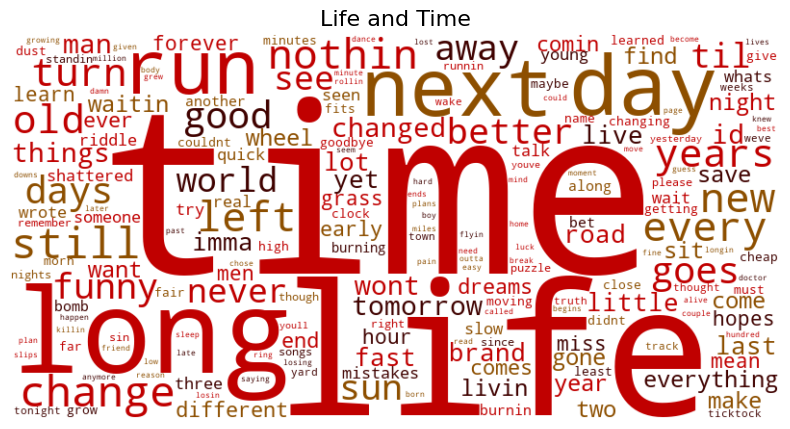

Top 10 most popular words with their counts for Life and Time:
time: 60
life: 43
long: 42
day: 17
next: 16
run: 14
change: 13
still: 13
every: 12
left: 12


In [24]:
generate_wordcloud_and_top_words('Life and Time')

### Consumption and Indulgence

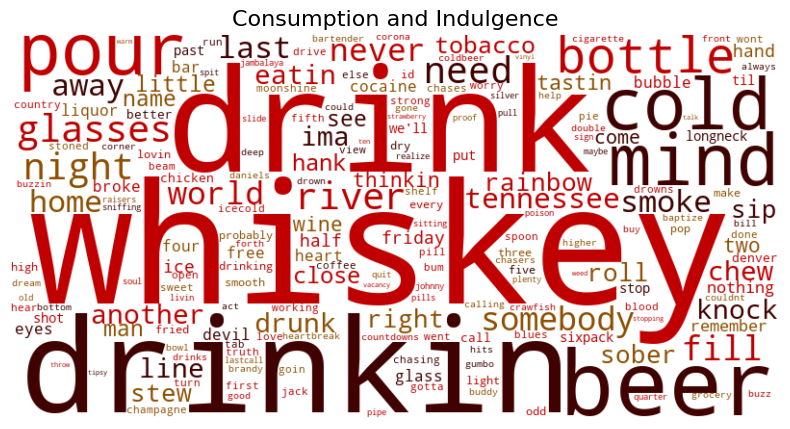

Top 10 most popular words with their counts for Consumption and Indulgence:
whiskey: 55
drink: 39
drinkin: 32
beer: 30
cold: 17
mind: 17
pour: 17
bottle: 15
glasses: 15
river: 15


In [25]:
generate_wordcloud_and_top_words('Consumption and Indulgence')

### Nature and the Environment

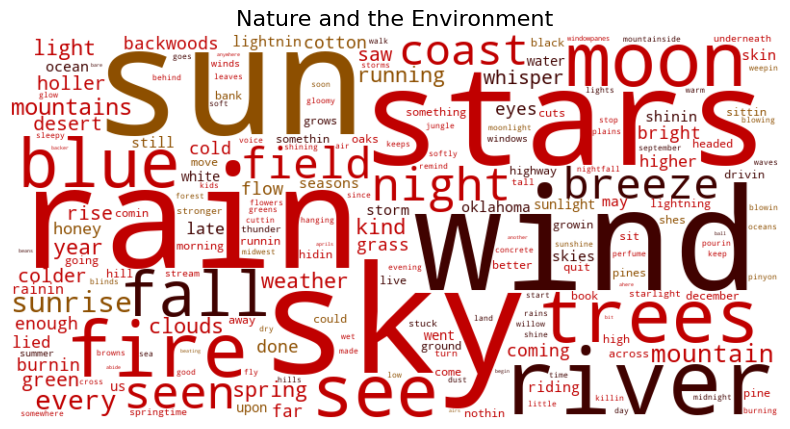

Top 10 most popular words with their counts for Nature and the Environment:
sun: 24
sky: 23
rain: 21
wind: 21
stars: 19
river: 18
fire: 12
moon: 12
trees: 12
see: 11


In [26]:
generate_wordcloud_and_top_words('Nature and the Environment')

### Gears and Gasoline

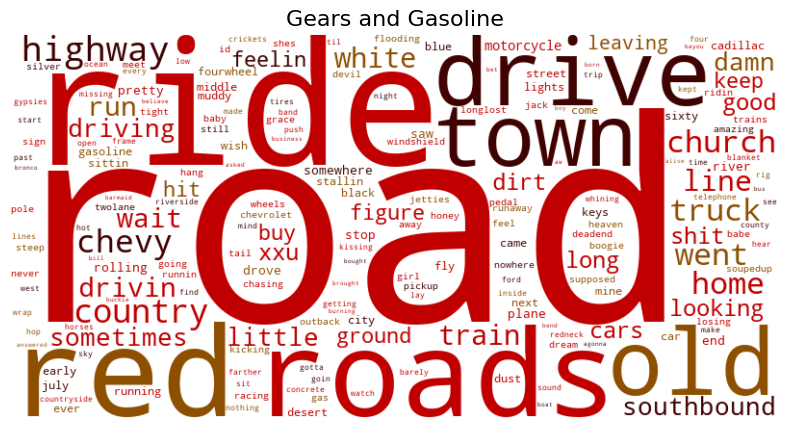

Top 10 most popular words with their counts for Gears and Gasoline:
road: 33
ride: 28
red: 20
roads: 20
drive: 17
old: 17
town: 17
highway: 16
country: 15
chevy: 14


In [27]:
generate_wordcloud_and_top_words('Gears and Gasoline')

### Occupations, Work, and Money

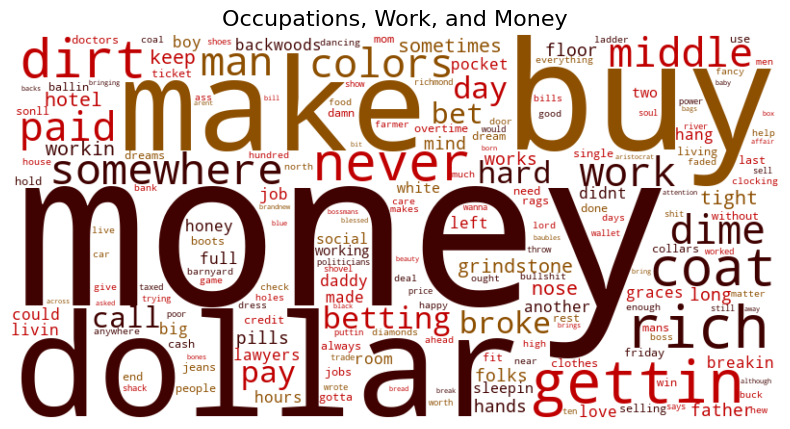

Top 10 most popular words with their counts for Occupations, Work, and Money:
money: 20
buy: 17
dollar: 15
make: 12
gettin: 11
rich: 11
coat: 9
dirt: 9
never: 9
somewhere: 9


In [28]:
generate_wordcloud_and_top_words('Occupations, Work, and Money')

### Geographic Identities

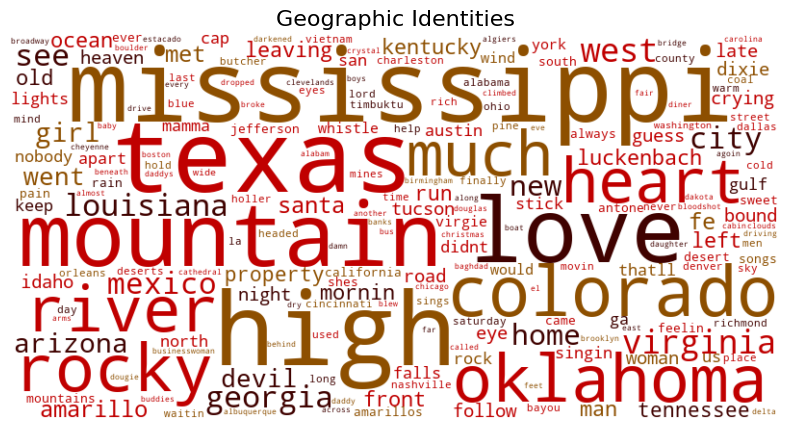

Top 10 most popular words with their counts for Geographic Identities:
high: 25
mississippi: 25
texas: 25
love: 20
mountain: 19
colorado: 18
oklahoma: 16
rocky: 16
river: 15
heart: 14


In [29]:
generate_wordcloud_and_top_words('Geographic Identities')

### Age, Nostalgia, and Memory

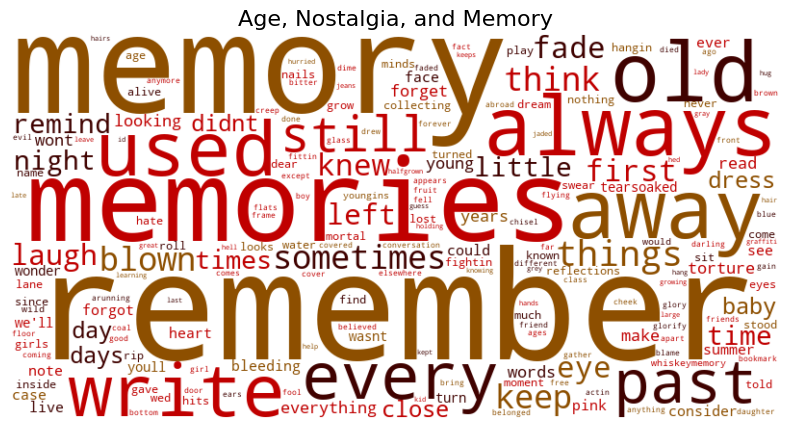

Top 10 most popular words with their counts for Age, Nostalgia, and Memory:
remember: 24
memory: 20
memories: 13
always: 12
away: 12
old: 12
used: 10
write: 10
every: 8
past: 8


In [30]:
generate_wordcloud_and_top_words('Age, Nostalgia, and Memory')

### Music, Dance, and Celebration

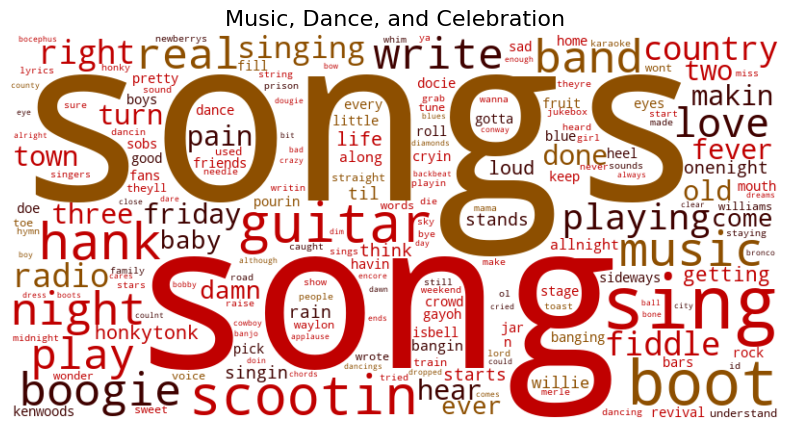

Top 10 most popular words with their counts for Music, Dance, and Celebration:
songs: 20
song: 19
sing: 16
boot: 11
guitar: 11
scootin: 11
hank: 10
music: 9
band: 8
boogie: 8


In [31]:
generate_wordcloud_and_top_words('Music, Dance, and Celebration')

### Outliers

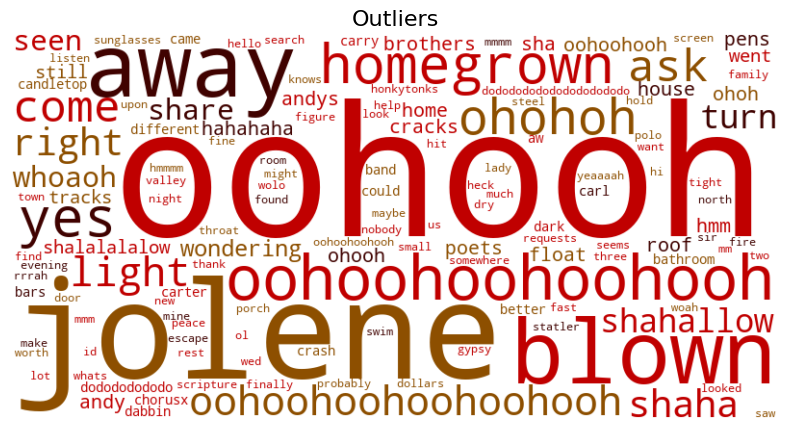

Top 10 most popular words with their counts for Outliers:
oohooh: 52
jolene: 26
away: 8
blown: 8
oohoohoohoohooh: 8
homegrown: 6
yes: 6
ohohoh: 5
ask: 4
come: 4


In [32]:
generate_wordcloud_and_top_words('Outliers')

### Americana

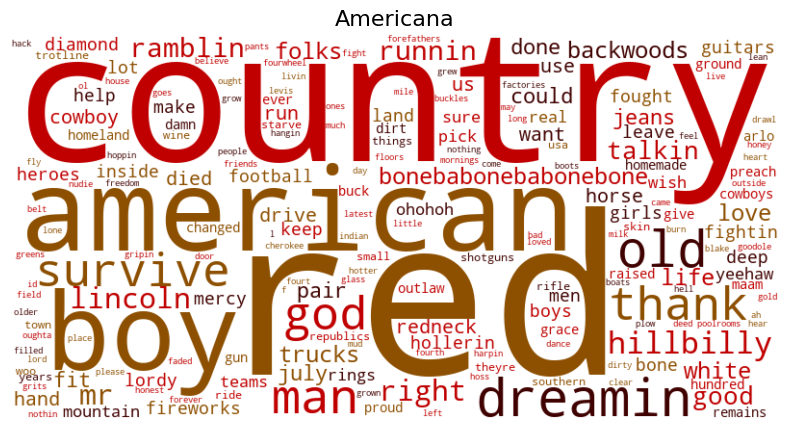

Top 10 most popular words with their counts for Americana:
red: 33
country: 32
american: 22
boy: 19
dreamin: 15
old: 14
man: 13
god: 12
survive: 12
thank: 12


In [33]:
generate_wordcloud_and_top_words('Americana')

### Hobbies, Pastimes, and Jokes

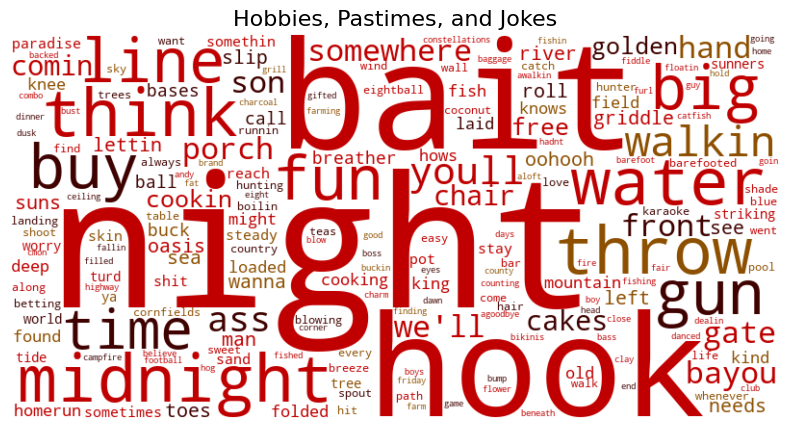

Top 10 most popular words with their counts for Hobbies, Pastimes, and Jokes:
night: 11
bait: 7
hook: 7
midnight: 7
think: 7
throw: 7
water: 7
big: 6
buy: 6
fun: 6


In [34]:
generate_wordcloud_and_top_words('Hobbies, Pastimes, and Jokes')

### Freedom and Independence

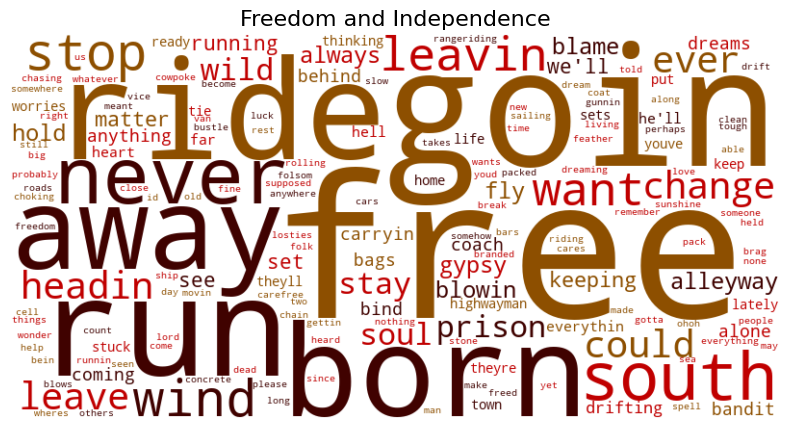

Top 10 most popular words with their counts for Freedom and Independence:
free: 16
goin: 12
ride: 8
run: 8
born: 7
away: 6
never: 6
south: 6
stop: 6
wind: 6


In [35]:
generate_wordcloud_and_top_words('Freedom and Independence')

### Law and Justice

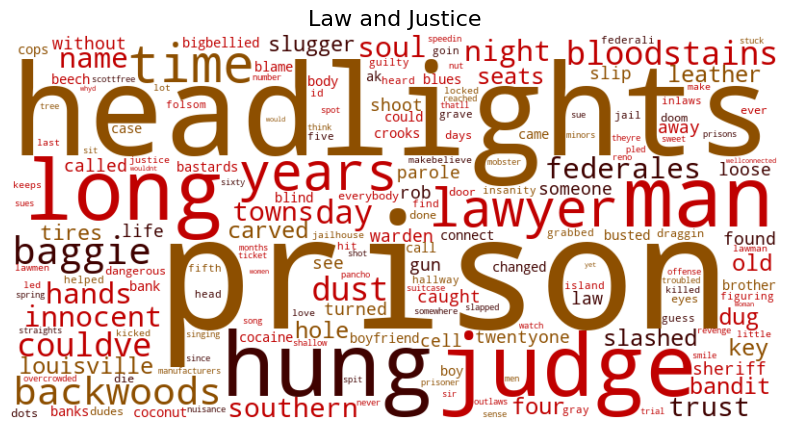

Top 10 most popular words with their counts for Law and Justice:
prison: 7
headlights: 6
hung: 6
judge: 6
long: 6
man: 6
lawyer: 5
time: 5
years: 5
backwoods: 4


In [36]:
generate_wordcloud_and_top_words('Law and Justice')

### Animals

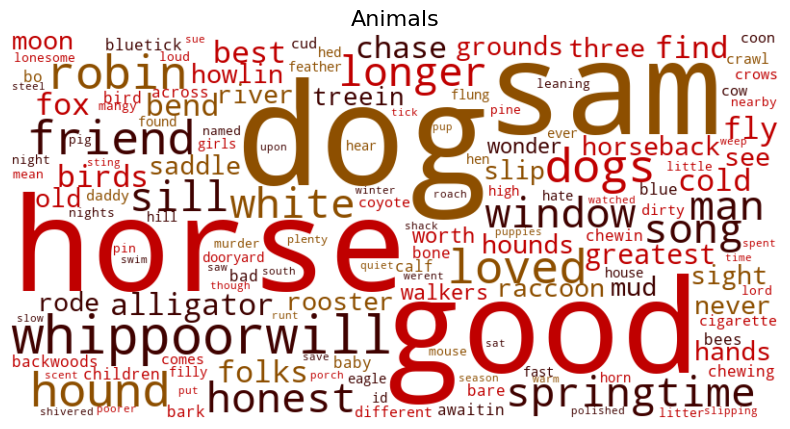

Top 10 most popular words with their counts for Animals:
dog: 6
good: 5
horse: 5
sam: 5
whippoorwill: 5
dogs: 4
friend: 4
hound: 4
loved: 4
robin: 4


In [37]:
generate_wordcloud_and_top_words('Animals')

### Technology and Modern Life

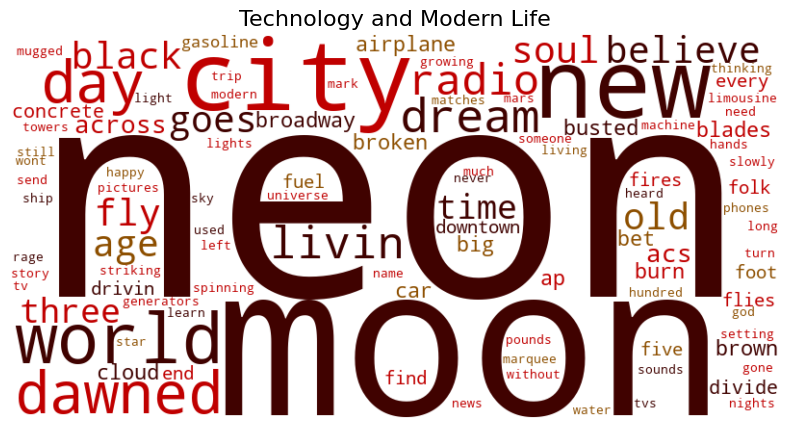

Top 10 most popular words with their counts for Technology and Modern Life:
neon: 11
moon: 8
city: 5
new: 5
world: 4
dawned: 3
day: 3
dream: 3
livin: 3
radio: 3


In [38]:
generate_wordcloud_and_top_words('Technology and Modern Life')

### Head over to the [Classifying-Country-Part-II.ipynb](./Classifying-Country-Part-II.ipynb) script. <br><br> There, you’ll find detailed profiles of the featured artists. <br><br> Dive in and enjoy discovering more about their lyrical themes and influences!